In [13]:
# imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# EDA: European Bank Customer Retention
**Purpose:** Inspect the dataset, fix formatting issues, understand distributions, and produce visual summaries to guide feature engineering and modeling.

**Inputs:** `../data/raw/friance_new.csv`  
**Outputs:** `../data/processed/bank_clean.csv` (cleaned dataset saved at the end)


In [14]:
raw_path = r"C:\Users\HP\Downloads\friance_new.csv"
df = pd.read_csv(raw_path)
print("ROWS x COLS:", df.shape)
display(df.columns.tolist())
df.head(5)


ROWS x COLS: (175028, 25)


C:\Users\HP\AppData\Local\Temp\ipykernel_47860\1782248130.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(raw_path)


['Surname',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Surname_tfidf_0',
 'Surname_tfidf_1',
 'Surname_tfidf_2',
 'Surname_tfidf_3',
 'Surname_tfidf_4',
 'France',
 'Germany',
 'Spain',
 'Female',
 'Male',
 'Mem__no__Products',
 'Cred_Bal_Sal',
 'Bal_sal',
 'Tenure_Age',
 'Age_Tenure_product']

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,France,Germany,Spain,Female,Male,Mem__no__Products,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,2023,668.0,33.0,3.0,0.00,2.0,1,0,181449.97,0,...,1,0,0,0,1,0.0,0.0,0.0,"9.090.909.090.909.090,00",99.0
1,2024,627.0,33.0,1.0,0.00,2.0,1,1,49503.5,0,...,1,0,0,0,1,2.0,0.0,0.0,"30.303.030.303.030.300,00",33.0
2,1236,678.0,40.0,10.0,0.00,2.0,1,0,184866.69,0,...,1,0,0,0,1,0.0,0.0,0.0,0.25,400.0
3,1362,581.0,34.0,2.0,148882.54,1.0,1,1,84560.88,0,...,1,0,0,0,1,1.0,"10.229.405.812.711.500,00","17.606.550.452.171.200,00","58.823.529.411.764.700,00",68.0
4,491,716.0,33.0,5.0,0.00,2.0,1,1,15068.83,0,...,0,0,1,0,1,2.0,0.0,0.0,"15.151.515.151.515.100,00",165.0


Initial checks: we expect to fix European numeric formats, drop useless columns like `Surname`, convert `EstimatedSalary` to numeric, and make sure the target is `Exited`.

In [15]:
# Helper to convert European-style numbers like '1.234.567,89' -> 1234567.89
def clean_euro_number(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    # some values contain thousands-separators (.) and decimal (,) or weird spaces
    s = s.replace(' ', '').replace('\xa0','')
    # remove grouping dots and convert comma to dot
    s = s.replace('.', '').replace(',', '.')
    # handle empty strings
    if s == '':
        return np.nan
    try:
        return float(s)
    except:
        return np.nan


In [16]:
# Drop columns that are not needed or clearly wrong
cols_to_drop = ['Surname', 'Mem__no__Products']  
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

# Columns observed to be using European formatting (based on inspection)
possible_euro_cols = [
    'Surname_tfidf_0','Surname_tfidf_1','Surname_tfidf_2','Surname_tfidf_3','Surname_tfidf_4',
    'Cred_Bal_Sal','Bal_sal','Tenure_Age'
]
# Apply conversion where the column exists
for col in possible_euro_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_euro_number)

# EstimatedSalary conversion
if 'EstimatedSalary' in df.columns:
    df['EstimatedSalary'] = df['EstimatedSalary'].apply(clean_euro_number)

# Ensure numeric columns are numeric
num_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited','Age_Tenure_product']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')


In [18]:
# summary
print("Data types:")
display(df.dtypes)

print("\nMissing value counts (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

Data types:


CreditScore           float64
Age                   float64
Tenure                float64
Balance               float64
NumOfProducts         float64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Surname_tfidf_0       float64
Surname_tfidf_1       float64
Surname_tfidf_2       float64
Surname_tfidf_3       float64
Surname_tfidf_4       float64
France                  int64
Germany                 int64
Spain                   int64
Female                  int64
Male                    int64
Cred_Bal_Sal          float64
Bal_sal               float64
Tenure_Age            float64
Age_Tenure_product    float64
dtype: object


Missing value counts (top 20):


CreditScore        0
Surname_tfidf_3    0
Tenure_Age         0
Bal_sal            0
Cred_Bal_Sal       0
Male               0
Female             0
Spain              0
Germany            0
France             0
Surname_tfidf_4    0
Surname_tfidf_2    0
Age                0
Surname_tfidf_1    0
Surname_tfidf_0    0
Exited             0
EstimatedSalary    0
IsActiveMember     0
HasCrCard          0
NumOfProducts      0
dtype: int64

**Notes:**
- Columns with many NaNs or still text-like should be inspected further.
- We converted several columns to numeric; any extreme values should be checked for outliers.
- Next step: quick univariate distributions for key features and the target.

Exited distribution:


,proportion
Exited,
0,0.788851
1,0.211149


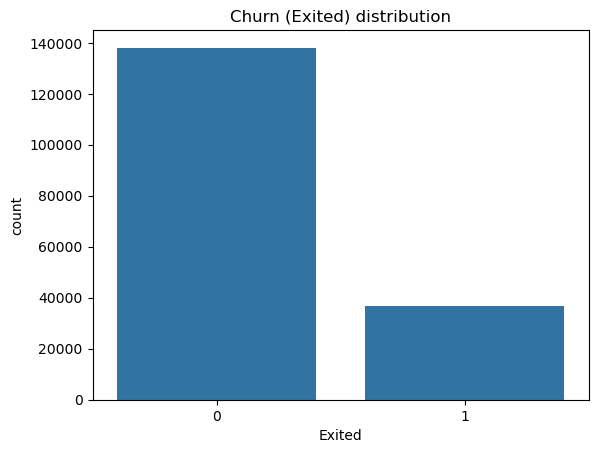

In [19]:
# Target distribution
if 'Exited' in df.columns:
    print("Exited distribution:")
    display(df['Exited'].value_counts(normalize=True).rename('proportion').to_frame())
    sns.countplot(x='Exited', data=df)
    plt.title('Churn (Exited) distribution')
    plt.show()
else:
    print("Target column 'Exited' not found; please confirm.")


,count,mean,std,min,25%,50%,75%,max
CreditScore,175028.0,6.561131e+02,8.114827e+01,350.00,5.970000e+02,6.590000e+02,7.100000e+02,8.500000e+02
Age,175028.0,3.817134e+01,8.969565e+00,18.00,3.200000e+01,3.700000e+01,4.200000e+01,9.200000e+01
Tenure,175028.0,5.019968e+00,2.811155e+00,0.00,3.000000e+00,5.000000e+00,7.000000e+00,1.000000e+01
Balance,175028.0,5.667677e+04,6.298242e+04,0.00,0.000000e+00,0.000000e+00,1.207280e+05,2.508981e+05
NumOfProducts,175028.0,1.553072e+00,5.492118e-01,1.00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
EstimatedSalary,175028.0,3.911074e+06,6.019365e+06,11.58,9.586351e+04,1.615799e+05,7.654484e+06,3.819017e+07
Age_Tenure_product,175028.0,1.913469e+02,1.187458e+02,0.00,9.300000e+01,1.800000e+02,2.720000e+02,8.800000e+02
Cred_Bal_Sal,175028.0,5.383688e+15,1.024817e+16,0.00,0.000000e+00,0.000000e+00,6.598084e+15,8.140013e+16
Bal_sal,175028.0,4.690652e+15,7.503073e+15,0.00,0.000000e+00,0.000000e+00,8.088645e+15,7.926918e+16
Tenure_Age,175028.0,1.121604e+16,1.133496e+16,0.00,1.891892e+15,8.620690e+15,1.739130e+16,6.122449e+16


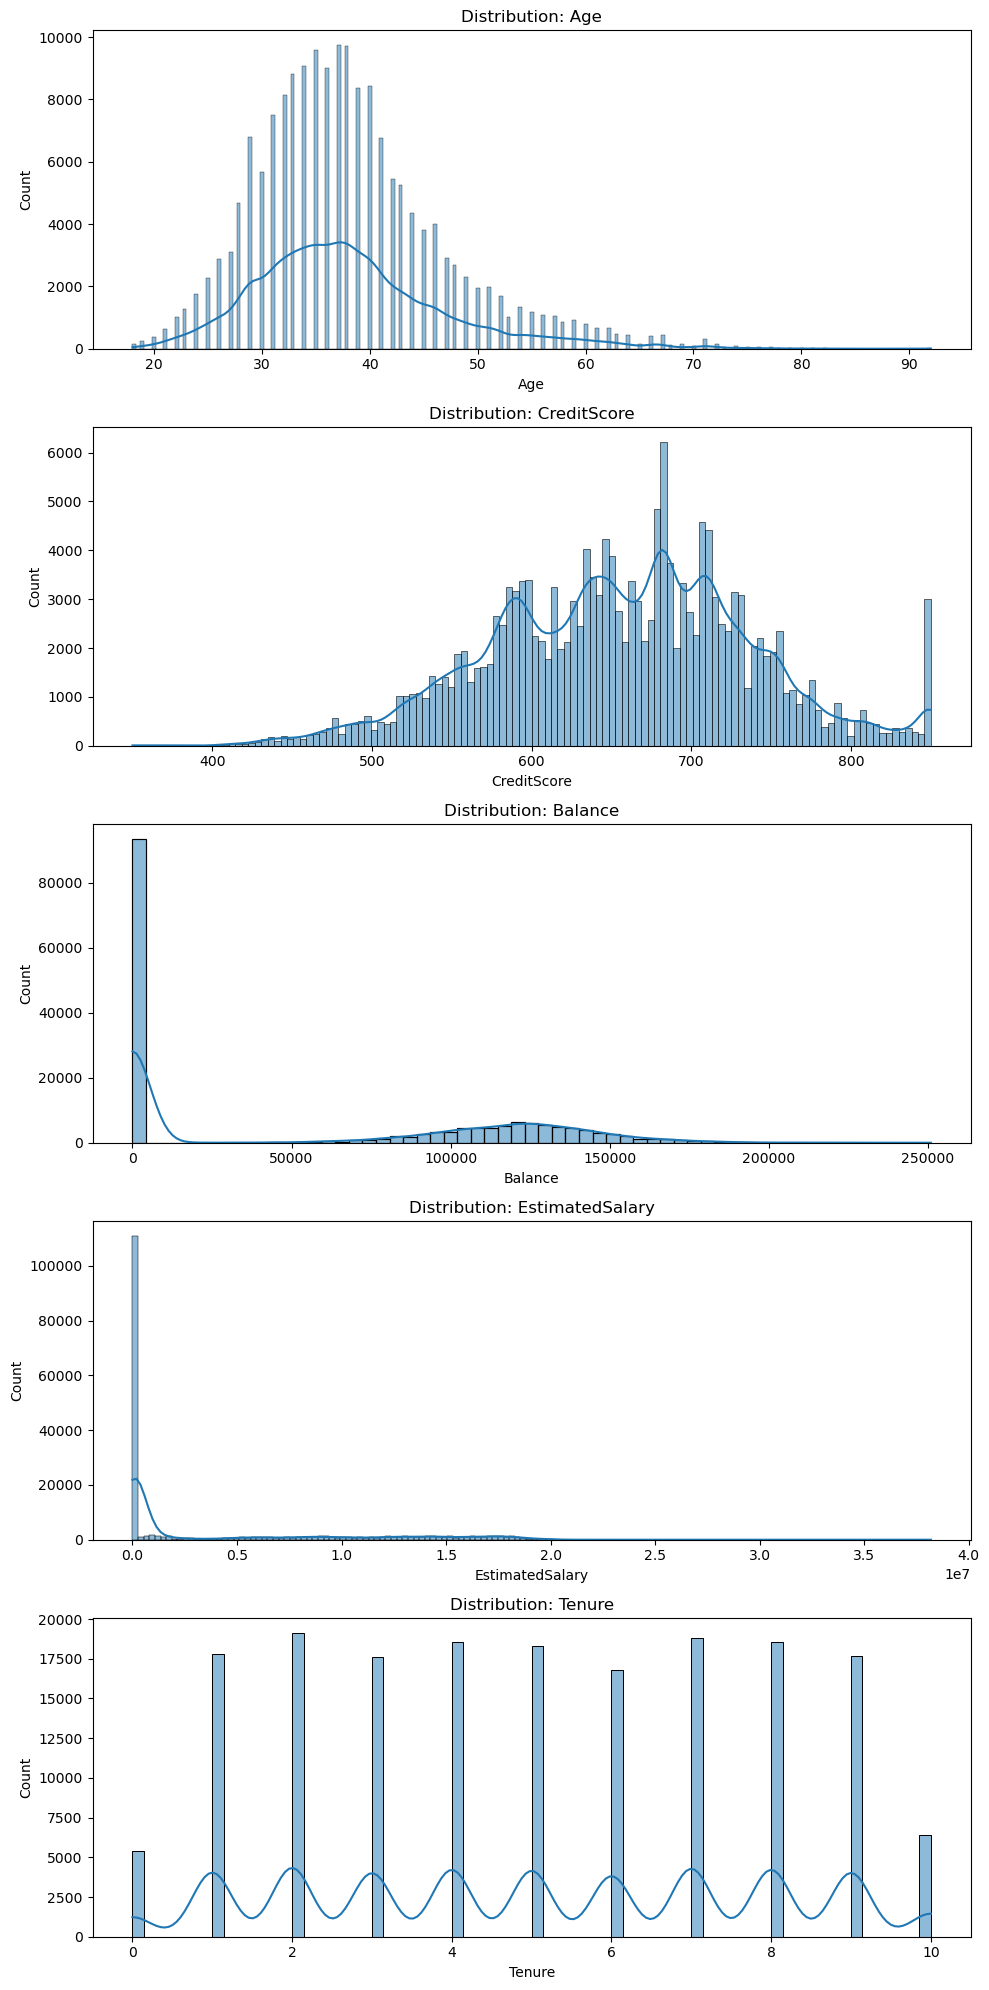

In [20]:
num_features = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Age_Tenure_product','Cred_Bal_Sal','Bal_sal','Tenure_Age']
num_features = [c for c in num_features if c in df.columns]

display(df[num_features].describe().T)

# Histograms for a selected subset
plot_cols = [c for c in ['Age','CreditScore','Balance','EstimatedSalary','Tenure'] if c in df.columns]
fig, axes = plt.subplots(len(plot_cols), 1, figsize=(10, 4*len(plot_cols)))
for ax, c in zip(axes, plot_cols):
    sns.histplot(df[c].dropna(), ax=ax, kde=True)
    ax.set_title(f"Distribution: {c}")
plt.tight_layout()
plt.show()

,count
France,
1,99225
0,75803


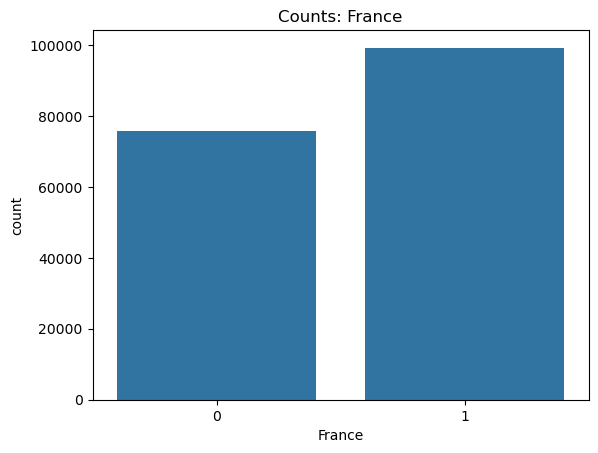

,count
Germany,
0,137914
1,37114


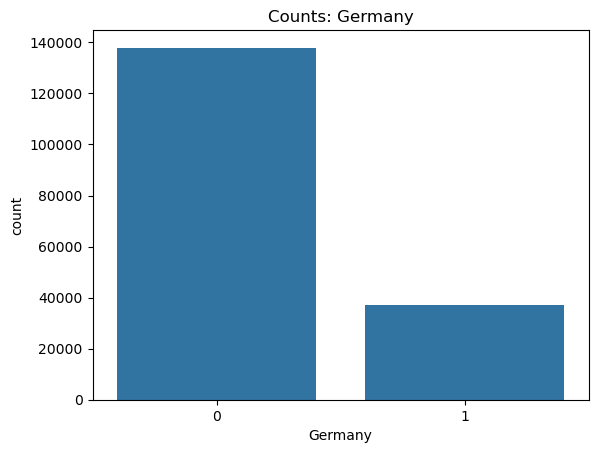

,count
Spain,
0,136339
1,38689


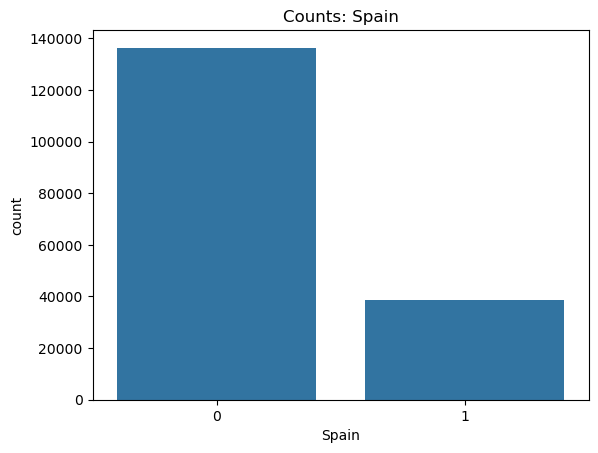

,count
Female,
0,98603
1,76425


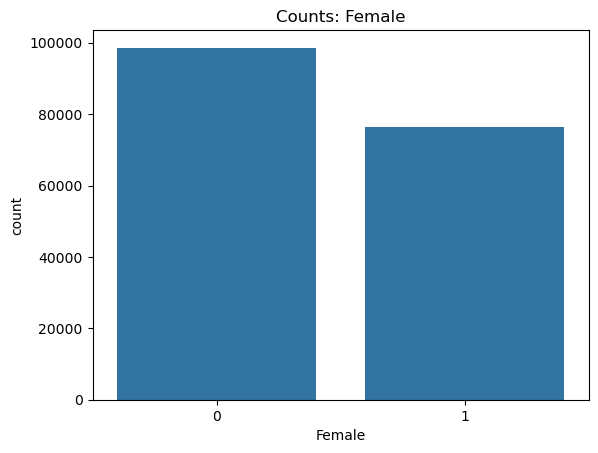

,count
Male,
1,98603
0,76425


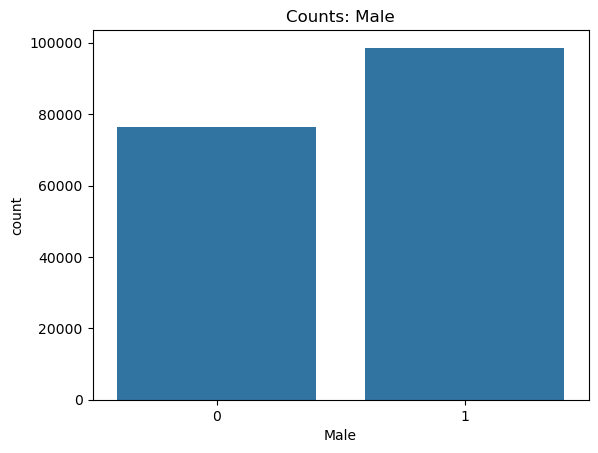

,count
HasCrCard,
1,131478
0,43550


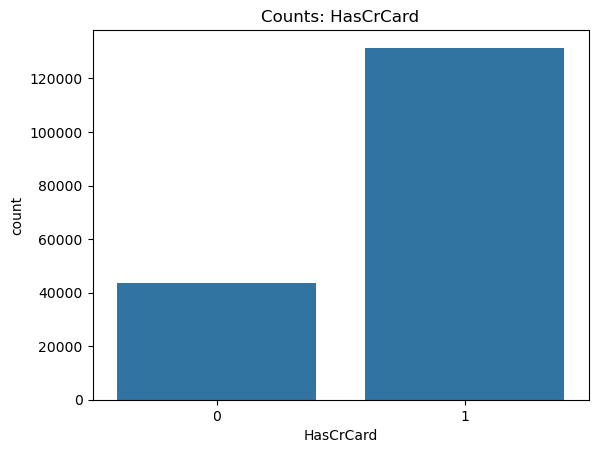

,count
IsActiveMember,
0,87732
1,87296


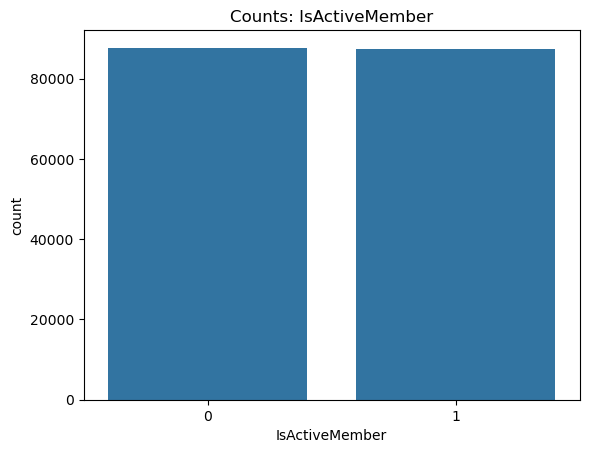

,count
NumOfProducts,
2.0,88878
1.0,82455
3.0,3160
4.0,535


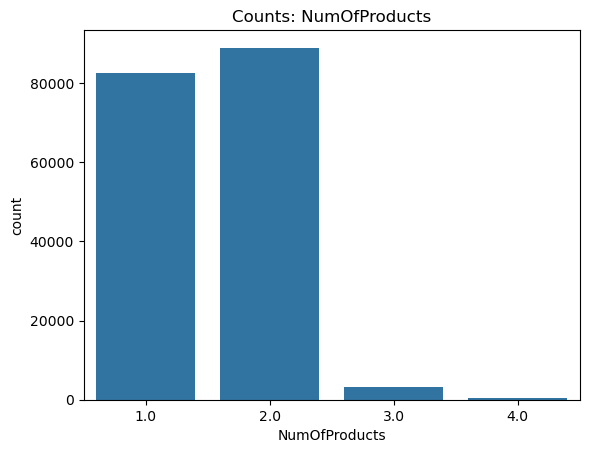

In [21]:
cat_features = [c for c in ['France','Germany','Spain','Female','Male','HasCrCard','IsActiveMember','NumOfProducts'] if c in df.columns]
for c in cat_features:
    if df[c].nunique() <= 10:
        display(df[c].value_counts().to_frame(name='count'))
        sns.countplot(x=c, data=df)
        plt.title(f"Counts: {c}")
        plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_47860\1389565031.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df.groupby(col)['Exited'].mean().sort_values(ascending=False)


,churn_rate
age_bucket,
45-55,0.568452
55-65,0.509124
35-45,0.205239
65+,0.180740
<25,0.090343
25-35,0.087284


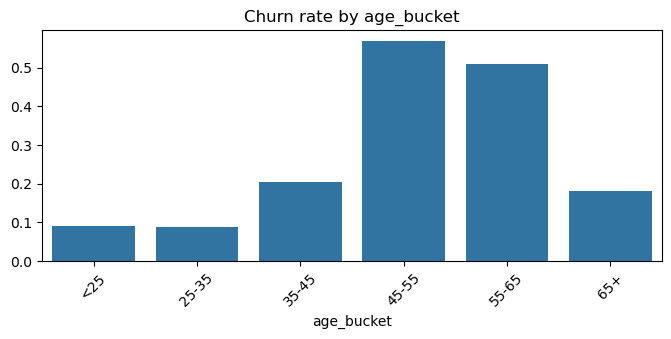

C:\Users\HP\AppData\Local\Temp\ipykernel_47860\1389565031.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = df.groupby(col)['Exited'].mean().sort_values(ascending=False)


,churn_rate
tenure_bucket,
0-1,0.232307
3-5,0.222319
1-3,0.210705
5-10,0.199826
10+,NaN


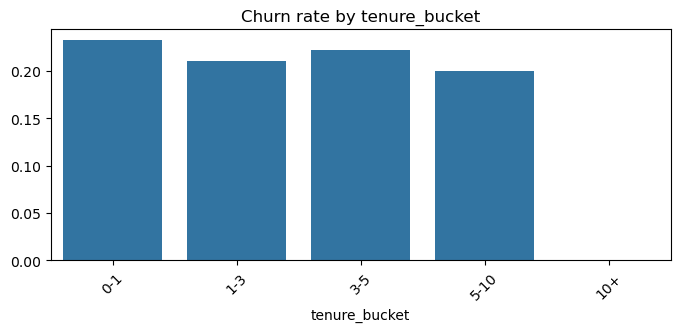

,churn_rate
NumOfProducts,
4.0,0.889720
3.0,0.877848
1.0,0.342817
2.0,0.061207


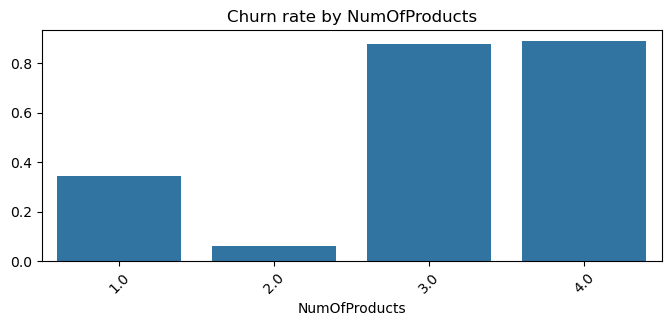

,churn_rate
IsActiveMember,
0,0.295502
1,0.126375


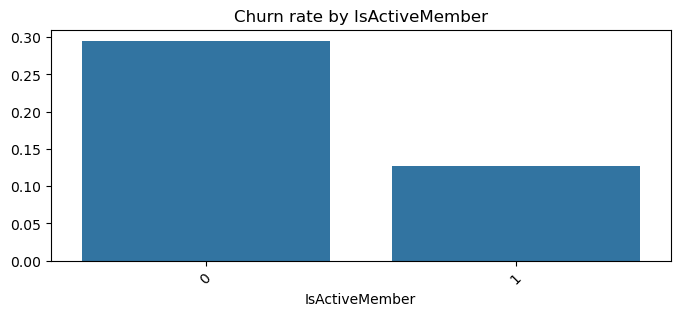

,churn_rate
HasCrCard,
0,0.226131
1,0.206187


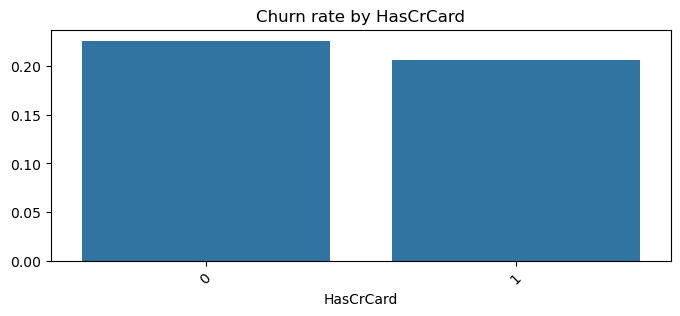

,churn_rate
France,
0,0.271427
1,0.165100


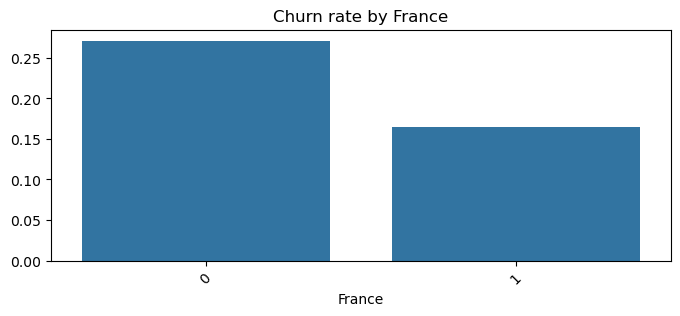

,churn_rate
Germany,
1,0.375249
0,0.166988


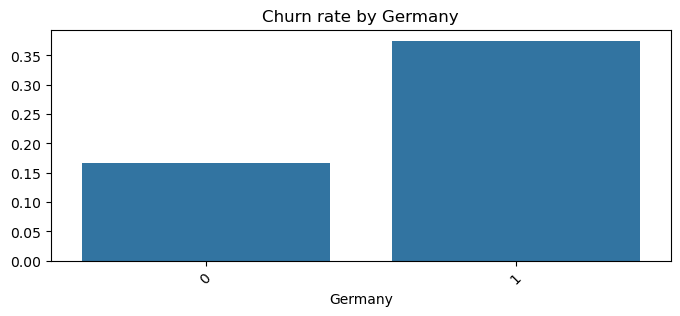

,churn_rate
Spain,
0,0.222306
1,0.171832


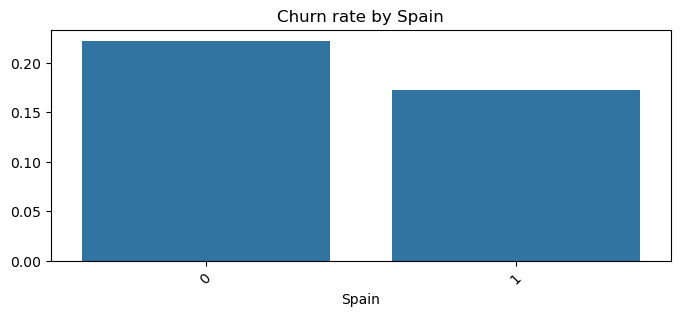

In [22]:
# churn rate by bucketed Age, Tenure, CreditScore
if 'Exited' in df.columns:
    df['age_bucket'] = pd.cut(df['Age'].fillna(-1), bins=[0,25,35,45,55,65,100], labels=['<25','25-35','35-45','45-55','55-65','65+'])
    df['tenure_bucket'] = pd.cut(df['Tenure'].fillna(-1), bins=[-1,1,3,5,10,100], labels=['0-1','1-3','3-5','5-10','10+'])
    for col in ['age_bucket','tenure_bucket','NumOfProducts','IsActiveMember','HasCrCard','France','Germany','Spain']:
        if col in df.columns:
            pivot = df.groupby(col)['Exited'].mean().sort_values(ascending=False)
            display(pivot.to_frame("churn_rate"))
            plt.figure(figsize=(8,3))
            sns.barplot(x=pivot.index, y=pivot.values)
            plt.title(f"Churn rate by {col}")
            plt.xticks(rotation=45)
            plt.show()

,corr_with_exited
Exited,1.000000
Age,0.336603
Balance,0.128391
Age_Tenure_product,0.107580
Bal_sal,0.083554
Cred_Bal_Sal,0.078092
EstimatedSalary,0.006155
Tenure_Age,0.005042
Tenure,-0.019237
CreditScore,-0.027252


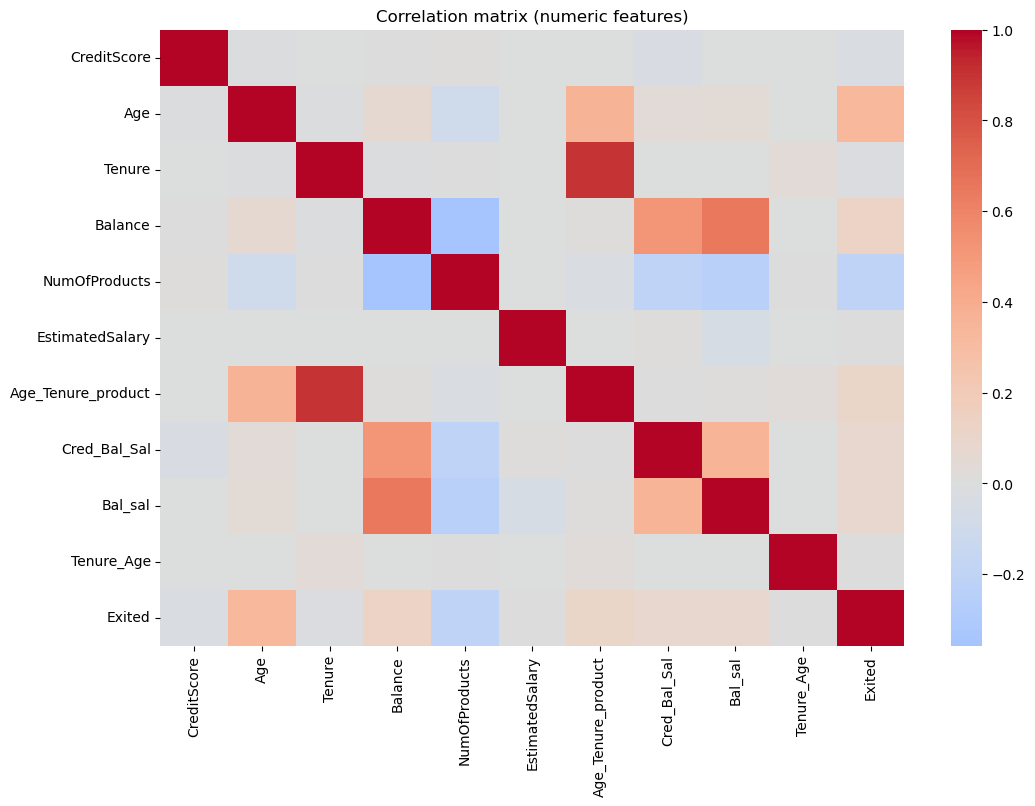

In [23]:
# correlation for numeric features with target
corr = df[num_features + ['Exited']].corr()
display(corr['Exited'].sort_values(ascending=False).to_frame('corr_with_exited'))

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

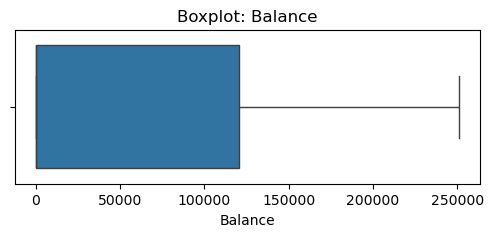

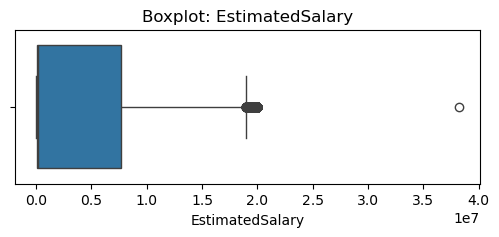

In [24]:
# Boxplots to detect outliers
for c in ['Balance','EstimatedSalary']:
    if c in df.columns:
        plt.figure(figsize=(6,2))
        sns.boxplot(x=df[c].dropna())
        plt.title(f"Boxplot: {c}")
        plt.show()

Exited,0,1
country,,
France,0.835,0.165
Germany,0.625,0.375
Spain,0.828,0.172


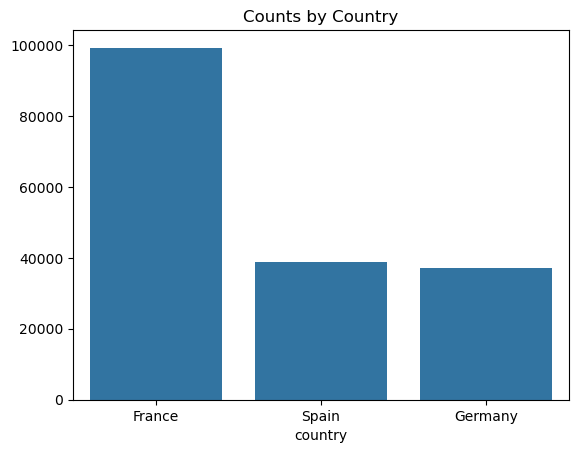

,churn_rate
NumOfProducts,
1.0,0.342817
2.0,0.061207
3.0,0.877848
4.0,0.889720


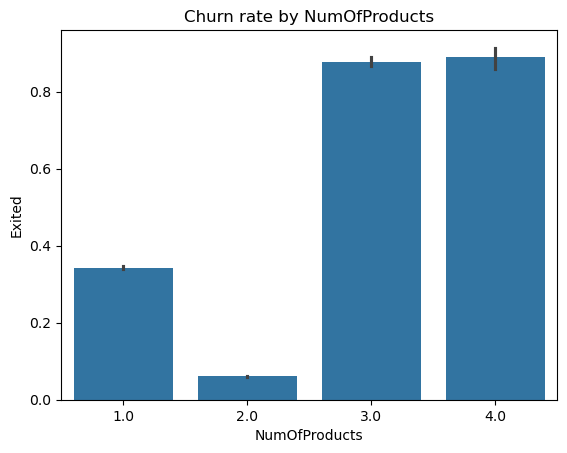

In [25]:
if 'France' in df.columns and 'Germany' in df.columns and 'Spain' in df.columns:
    df['country'] = np.select([df['France']==1, df['Germany']==1, df['Spain']==1], ['France','Germany','Spain'], default='Other')
    display(pd.crosstab(df['country'], df['Exited'], normalize='index').round(3))
    sns.barplot(x=df['country'].value_counts().index, y=df['country'].value_counts().values)
    plt.title("Counts by Country")
    plt.show()

if 'NumOfProducts' in df.columns:
    display(df.groupby('NumOfProducts')['Exited'].mean().to_frame('churn_rate'))
    sns.barplot(x='NumOfProducts', y='Exited', data=df)
    plt.title("Churn rate by NumOfProducts")
    plt.show()

In [27]:
# Save cleaned full dataset for modeling/Power BI import
out_path = r"C:\Users\HP\Documents\anaconda_projects\European-Bank-Customer-Retention/data/processed/bank_clean.csv"
df.to_csv(out_path, index=False)
print("Saved cleaned dataset to:", out_path)

Saved cleaned dataset to: C:\Users\HP\Documents\anaconda_projects\European-Bank-Customer-Retention/data/processed/bank_clean.csv
